### GLM-eb 
@author: Jordan, Ben

#### setup:

In [1]:
# preamble
import scipy.io
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import scipy.sparse as sps
import scipy.stats as stats
from pyglmnet import GLM, simulate_glm
import scipy as sp
import statistics

In [67]:
# visualization parameters
plt.rcParams['figure.figsize'] = (4,2)
plt.rc('axes', labelsize=10); plt.rc('axes', titlesize=10)
plt.style.use('ggplot'); plt.rc('font', size=10);

In [68]:
# load & format data
filepath = 'sampleData.mat'
mat = scipy.io.loadmat(filepath)
ST = mat['ST']; P = mat['P']; hd = mat['hd']

#### define methods:

In [74]:
class glm:
    def __init__(self, ST, P, hd):
        self.ST = ST
        self.P = P
        self.x = P[:,1]
        self.y = P[:,2]
        self.t = P[:,0]
        self.hd = (hd[:,0]*np.pi)/180; # 0-2pi
        self.dt = np.round(statistics.mode(np.diff(P[:,0])),2);
        
    def get_size(self):
        '''get size of recording box'''
        boxsz = np.max([np.max(self.x), np.max(self.y)]);
        return boxsz
    
    def pos_map(self, nbins=10):
        '''design matrix for position variables'''
        boxsz = self.get_size()
        bins = np.arange(boxsz/nbins/2, boxsz-boxsz/nbins/2, boxsz/nbins)
        posgrid = np.zeros((len(self.x), nbins**2))
        for idx,val in enumerate(self.x):
            xvec = np.abs(self.x[idx]-bins); yvec = np.abs(self.y[idx]-bins);
            min_x = np.min(xvec)
            min_y = np.min(yvec)
            idx_x = np.where(xvec == min_x); idx_x = idx_x[0][0];
            idx_y = np.where(yvec == min_y); idx_y = idx_y[0][0];
            bin_idx = np.ravel_multi_index((idx_y,idx_x), dims=(nbins,nbins), order='C') # a11=0, a12=1, a13=2;
            posgrid[idx, bin_idx] = 1;
        return posgrid, bins
    
    def eb_map(self, nbins=10, rp=[75,75]):
        '''design matrix for egocentric variables'''
        refx = rp[0]; refy = rp[1];
        allo = np.arctan2(refy-self.y, refx-self.x) + (np.pi/2); # add 90 deg
        allo[allo<0] = allo[allo<0]+2*np.pi;
        ego = allo - self.hd; # shift from 0-2pi
        egogrid = np.zeros((len(P),nbins));
        bins = np.arange(2*np.pi/nbins/2, 2*np.pi-2*np.pi/nbins/2, 2*np.pi/nbins) # 10 bin ctrs
        for idx,val in enumerate(P):
            evec = np.abs(ego[idx]-bins)
            min_e = np.min(evec)
            idx_e = np.where(evec == min_e)
            egogrid[idx, idx_e] = 1;
        return egogrid, bins
    
    def conv_spktrain(self, Xx=np.linspace(-4,4,9),
                      sigma=2,c=0,defaultST=True,spikeIn=[1,2,3],dt=0.02):
        '''get smoothed spiketrain from spiketimes
            **kwargs:
            spikeTrain- 'False' if user wants self.ST (spiketimes)
                        'True' if user wants to use a pre-allocated spiketrain
            spikeIn-    use this optional kwarg iff spikeTrain==True
        '''
        if defaultST==True:
            t = self.P[:,0]; dt = self.P[1,0]-self.P[0,0]; # time per frame
            boolean_spk = np.logical_and(t[0] <= self.ST, self.ST <= t[-1])
            spikes = self.ST[boolean_spk == True]
            edgesT = np.linspace(t[0], t[-1], len(t)+1)
            binnedSpikes, timeEdges = np.histogram(spikes, edgesT)
            
        elif defaultST==False:
            binnedSpikes = spikeIn
            
        # convolve w/ gaussian membership function
        filt = np.exp((-(Xx-c)**2)/(2*(sigma**2)))
        fr = binnedSpikes/dt # rate (hz)
        smooth_fr = np.convolve(binnedSpikes, filt, mode='same')
        
        return smooth_fr, binnedSpikes, filt, dt

    
    def get_speed(self):
        '''get speed of the animal (cm*s^-2)'''
        t=self.P[:,0]; x=self.P[:,1]; y=self.P[:,2];
        ntime = len(t); v = np.zeros((ntime,1));
        
        for idx in range(1,ntime-1):
            v[idx,0] = np.sqrt((x[idx+1]-x[idx-1])**2 + (y[idx+1]-y[idx-1])**2)/(t[idx+1]-t[idx-1])    
        v[0,0] = v[1,0]; v[-1,0] = v[-2,0] # pad the array
        
        return v
    
    def speed_threshold(self,posgrid,ebgrid,spiketrain):
        v = self.get_speed()
        maxspeed=50; minspeed=4
        inbounds = np.logical_and((v<=maxspeed), (v>=minspeed))
        inbounds = np.where(inbounds==True); inbounds = inbounds[0]
        posgrid = posgrid[inbounds,:]
        ebgrid = ebgrid[inbounds,:]
        spiketrain = spiketrain[inbounds]
        return posgrid, ebgrid, spiketrain
    
    def squish_statemat(self, spiketrain, stateIn, modelType='PE'):
        '''squish state matrix for 2-variable model (P+EB)
            inputs- spiketrain is the speed-thresholded spiketrain'''
        if modelType == 'PE':
            posgrid = stateIn[0]; ebgrid = stateIn[1]
            ntime,nbins_eb = np.shape(ebgrid)
            _,nbins_p = np.shape(posgrid)
            A = np.zeros((ntime, nbins_p+nbins_eb)) #P+EB
            A[:,0:nbins_p] = posgrid; A[:,nbins_p:] = ebgrid
            df=pd.DataFrame(A)
            # name columns & get expression
            colnames = [];
            expr = 'y ~ '
            for i in range(nbins_p):
                val = str(i);
                expr = expr + 'P' + val + ' + '
                colnames.append('P' + val)
            for i in range(nbins_eb-1):
                val = str(i);
                expr = expr + 'E' + val + ' + '
                colnames.append('E' + val)
            expr = expr + 'E9'
            colnames.append('E9')
            df.columns = colnames
        elif modelType == 'P':
            ntime,nbins = np.shape(stateIn)
            df = pd.DataFrame(stateIn)
            colnames = [];
            expr = 'y ~ '
            for i in range(nbins-1):
                val = str(i);
                expr = expr + 'P' + val + ' + '
                colnames.append('P' + val)
            expr = expr + 'P99'
            colnames.append('P99')
            df.columns = colnames
        elif modelType == 'E':
            ntime,nbins = np.shape(stateIn)
            df = pd.DataFrame(stateIn)
            colnames = [];
            expr = 'y ~ '
            for i in range(nbins-1):
                val = str(i);
                expr = expr + 'E' + val + ' + '
                colnames.append('E' + val)
            expr = expr + 'E9'
            colnames.append('E9')
            df.columns = colnames
        else:
            print('Error: model type must be "P", "E", or "PE"')
        # if you want to do a 20-80 test-train split
        # note: make this an option
        mask = np.random.rand(len(df)) < 0.8
        df_train = df[mask]; df_test = df[~mask]
        # insert [raw] spiketrain into dataframe
        df.insert(0, 'y', spiketrain)
        return df,expr
    
    def kfoldSplit(self,nfolds=10):
        '''train-test split for k-fold xval
            each section is ~1 min'''
        _, spiketrain, _, dt = self.conv_spktrain()
        # calculate number of chunks given session length
        nmins = (len(spiketrain)*dt)/60
        nchunks = int(round(nmins/nfolds))
        nsections = int(nchunks*nfolds)
        # grab indices for k-fold splitting
        kfoldIdx = {}
        howLong = np.zeros(nfolds)
        edges = np.round(np.linspace(1,len(spiketrain)+1,nsections+1))
        for k in range(nfolds):
            test_ind = np.floor(np.linspace(int(edges[k]),
                    (int(edges[k+1])-1),
                    (int(edges[k+1])-1)-int(edges[k])))
            for s in range(1,nchunks):
                ind = np.floor(np.linspace(int(edges[k+s*nfolds]),
                                  (int(edges[k+s*nfolds+1])-1),
                                  (int(edges[k+s*nfolds+1]))-int(edges[k+s*nfolds])))
                test_ind = np.append(test_ind,ind)
            kfoldIdx[k] = test_ind
            howLong[k] = len(test_ind); del test_ind;
        minArrLen = int(np.min(howLong));
        for k in range(nfolds):
            kfoldIdx[k] = kfoldIdx[k][0:minArrLen] # adjust arr. len (w/in .02 s)
        kfoldIdx_df = pd.DataFrame.from_dict(kfoldIdx)
        kfoldIdx_df = kfoldIdx_df.astype(int) # for idxing purposes
        return kfoldIdx, kfoldIdx_df
    
    def kfoldOptim(self,kfoldIdx_df,statemat):
        '''kfoldIdx_df can be retrieved from self.kfoldSplit()'''
        
        # intialize output structures
        _,nfolds=np.shape(kfoldIdx_df); k_vec = np.arange(nfolds)
        kres = {}; train_y = {}; train_x = {}; test_y = {}
        test_x = {}; train_y_raw = {}; test_y_raw = {}
        
        for foldnum in range(nfolds):
            k_vec_train = np.delete(k_vec, np.where(k_vec == foldnum))
            idx_test = kfoldIdx_df.loc[:,foldnum].to_numpy()
            idx_train = []
            
            # squeeze other nfolds-1 folds into one vector
            for i,v in enumerate(k_vec_train):
                nextRow = kfoldIdx_df.loc[:,v].to_numpy()
                idx_train = np.append(idx_train,nextRow) 
            idx_train = idx_train.astype(int)
            
            # train-test statemats
            df_test = statemat.loc[idx_test,:].dropna()
            df_train = statemat.loc[idx_train,:].dropna()
            y_test_raw = df_test['y'].to_numpy(dtype='int64');
            y_train_raw = df_train['y'].to_numpy(dtype='int64')
            
            # smooth firing rates
            y_test, _, _, _ = g.conv_spktrain(defaultST=False,spikeIn=y_test_raw)
            y_train, _, _, _ = g.conv_spktrain(defaultST=False,spikeIn=y_train_raw) 
            
            # put smoothed firing rates back into dataframe
            df_test[df_test.columns[0]] = y_test; 
            df_train[df_train.columns[0]] = y_train
            
            # test/train arrays
            X_test = df_test[df_test.columns[1:]].to_numpy(); y_test = df_test[df_test.columns[0]].to_numpy()
            X_train = df_train[df_train.columns[1:]].to_numpy(); y_train = df_train[df_train.columns[0]].to_numpy()
            
            # set some initial parameters
            M,n = np.shape(X_train)
            w_0 = 1e-3*np.ones((n, ))
            b_0 = 1
            # alpha = 0.001 (can't remember when we use this)
            
            # get parameters & jacobian (1st order derivatives of loss fn)
            data,param = self.getDataParam(X_train,y_train,w_0,b_0);
            jac = self.grad(param,X_train,y_train)
            
            # optimize loss function
            res = self.bfgs(data,param)
            
            # package outputs for each fold
            kres[foldnum] = res
            train_y[foldnum] = y_train; test_y[foldnum] = y_test
            train_x[foldnum] = X_train; test_x[foldnum] = X_test
            train_y_raw[foldnum] = y_train_raw; 
            test_y_raw[foldnum] = y_test_raw; 
            
            del y_test_raw, y_train_raw # for debugging
        return kres,train_y, test_y, train_x, test_x, train_y_raw, test_y_raw
    
    def init_params(self,whichVars={'P', 'E'}):
        if whichVars == {'P', 'E'}: init_param = 1e-3*np.random.randn(110, 1);
        if whichVars == {'P'}: init_param = 1e-3*np.random.randn(100, 1);
        if whichVars == {'E'}: init_param = 1e-3*np.random.randn(10, 1);
        return init_param
    
    def getDataParam(self,x,y,w,b):
        '''put param & data in a dictionary'''
        param = np.append(b,w)
        data =  (x, y)
        return data,param
    
    def get_rate(self,x,w,b):
        '''conditional intensity function'''
        # note: not normalized by dt (not in Hz)
        y_hat = np.exp(x @ w + b)
        return y_hat
    
    def loss(self,param,x,y):
        '''objective function'''
        
        y_hat = np.exp(x @ param[1:] + param[0])
        #negative log likelihood for possion where yhat is lambda
        error = (y_hat - np.log(y_hat) * y).mean()
        
        return error
    
    def grad(self,param,x,y):
        '''compute the gradient of the loss fn'''
        M, n = x.shape
        y_hat = np.exp(x @ param[1:] + param[0])
        dw = (x.T @ (y_hat - y)) / M
        db = (y_hat - y).mean() 
        # we dont really need [db] if the bias term is included as a column of 1's
        # which right now it is currently NOT
        jac = dw; jac=np.append(jac,db);
        return jac

    def gradient_descent(self,x, y, w_0, b_0, alpha, num_iter):
        '''minimize loss function w/ gradient descent'''
        w, b = w_0.copy(), b_0
        hist = np.zeros(num_iter)
        M, n = x.shape
        for iter in range(num_iter):
            dw, db = self.grad(x, y, w, b)
            w -= alpha * dw
            b -= alpha * db
            hist[iter] = self.loss(x, y, w, b)
        return w, b, hist
    
    def bfgs(self,data,param):
        'minimize loss function w/ L-BFGS-B'
        res = sp.optimize.minimize(self.loss, x0=param, args=data, method='L-BFGS-B', jac=self.grad)
        # options={'gtol': 1e-6, 'disp': True})
        return res
    
    def get_stats(self, y, y_hat):
        # compare between test fr and model fr
        sse = np.sum((y_hat-y)**2);
        sst = sum((y-np.mean(y))**2);
        varExplain_test = 1-(sse/sst)
        r, pval_r = stats.pearsonr(y,y_hat)
        return sse, sst, varExplain_test, r, pval_r
    
    def get_testFit(self,kres,train_y,test_y,train_x,test_x,train_y_raw,test_y_raw):
        '''get statistics for model fit'''
        # initialize output structures
        yhatDict={}
        nfolds=len(kres);
        sse=np.zeros(nfolds); sst=np.zeros(nfolds)
        varExplain_test=np.zeros(nfolds); pearson_r=np.zeros(nfolds)
        pearson_pval=np.zeros(nfolds); funval=np.zeros(nfolds)
        llh=np.zeros(nfolds)
        
        for fold in range(nfolds):
            # predict model output on *test* data
            yhat_raw = g.get_rate(test_x[fold],kres[fold].x[1:],kres[fold].x[0]) # not normalized
            yhat, _, _, _ = g.conv_spktrain(defaultST=False,spikeIn=yhat_raw) # normalized by dt (hz)
            
            # compare between test and model rates
            sse[fold] = np.sum((yhat-test_y[fold])**2); #sse
            sst[fold]= sum((test_y[fold]-np.mean(test_y[fold]))**2); #sst
            varExplain_test[fold] = 1-(sse[fold]/sst[fold]) #varExplained_test
            pearson_r[fold],pearson_pval[fold] = stats.pearsonr(test_y[fold],yhat) #pearsonsR,p-val
            funval[fold] = kres[fold].fun
            yhatDict[fold] = yhat
            
            #compute llh increase from "mean firing rate model"
            # NO SMOOTHING is used here
            bestp = kres[fold]['x'] # best parameters
            n = test_y_raw[fold]
            arrFactorial = np.vectorize(math.factorial) # array-wise factorial fn
            meanFR_test = np.nanmean(n)

            # format the state matrix
            b = np.ones((len(test_x[fold]),len(bestp)))
            b[:,1:] = test_x[fold]
            # get rate of 'mean fr model'
            r = np.exp(b@bestp) # predicted rate (not normalized by dt)
            
            # compute log-likelihood value for the test data
            log_llh_test_model = np.nansum(r-n*np.log(r)+np.log(arrFactorial(n)))/np.sum(n);
            log_llh_test_mean = np.nansum(meanFR_test-n*np.log(meanFR_test)+np.log(arrFactorial(n)))/np.sum(n);
            log_llh_test = (-log_llh_test_model + log_llh_test_mean);
            log_llh_test = np.log(2)*log_llh_test;
            llh[fold] = log_llh_test
            
            # akaike info criterion
            # log is undefined b/c llh is negative
            # AIC = 2*(len(bestp))-2*np.log(log_llh_test);
            
        # dictionary of statistics describing fit of test data to model
        testfit = {
            'llh_test': llh,
            'sse': sse,
            'sst': sst,
            'varEx': varExplain_test,
            'pearson_r': pearson_r,
            'pearson_pval': pearson_pval,
            'funval': funval,
            'yhat': yhatDict
        }
        return testfit
    
    def findBestModel(self,modelDict):
        '''modelDict is defined in the script below (incorporate)'''
        numModels = len(allModels)
        llh = np.zeros(numModels)
        for model in range(numModels):
            T = allModels[model]['testfit']
            llh[model] = np.nanmean(T['llh_test'])
        bestModel=np.where(llh==np.max(llh))[0][0]
        print('best model: ' + labelDict[bestModel])
        
        return llh, bestModel
    
    def plot_llh(self,allModels,labelDict):
        # plot log-likelihood values for each model
        numModels = len(allModels)
        nfolds = len(allModels[0]['kres'].keys())
        
        llh = {}; whichModel = {}
        for model in range(numModels):
            a = allModels[model]['testfit']['llh_test']
            a = a[None].T
            llh[model] = a
#             labels = np.ones((nfolds,1));
#             labels[:] = labelDict[model]
            whichModel[model] = np.ones((nfolds,1))*model

        llh = np.vstack((llh[0], llh[1], llh[2]))
        whichModel = np.vstack((whichModel[0], whichModel[1], whichModel[2]))
        df = pd.DataFrame(np.hstack((llh,whichModel)), columns = ['llh','whichModel'])
        ax = sns.swarmplot(x="whichModel", y="llh", data=df)

#### execute glm:

C:\Users\17145\.conda\envs\tdt4195\lib\site-packages\ipykernel_launcher.py:264: RuntimeWarning: divide by zero encountered in log
C:\Users\17145\.conda\envs\tdt4195\lib\site-packages\ipykernel_launcher.py:264: RuntimeWarning: invalid value encountered in multiply
C:\Users\17145\.conda\envs\tdt4195\lib\site-packages\ipykernel_launcher.py:262: RuntimeWarning: overflow encountered in exp
C:\Users\17145\.conda\envs\tdt4195\lib\site-packages\ipykernel_launcher.py:271: RuntimeWarning: overflow encountered in exp
C:\Users\17145\.conda\envs\tdt4195\lib\site-packages\ipykernel_launcher.py:272: RuntimeWarning: invalid value encountered in matmul
C:\Users\17145\.conda\envs\tdt4195\lib\site-packages\ipykernel_launcher.py:264: RuntimeWarning: invalid value encountered in subtract


best model: E


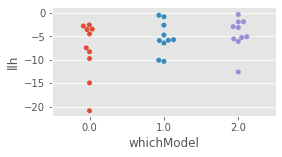

In [75]:
# initialize class instance
g = glm(ST,P,hd)

# prepare the data
posgrid_raw,bins = g.pos_map(nbins=10)
ebgrid_raw,bins = g.eb_map(nbins=10, rp=[75,75])
smooth_fr, raw_spktrn, filt, dt = g.conv_spktrain() # get spiketrain
posgrid,ebgrid,spiketrain = g.speed_threshold(posgrid_raw,ebgrid_raw,raw_spktrn)

# dictionaries with info about each model
stateDict = {
    0: [posgrid,ebgrid],
    1: posgrid,
    2: ebgrid
}

labelDict = {
    0: 'PE',
    1: 'P',
    2: 'E'
}

allModels = {}
numModels = 3

# get test/train indices (same for each model)
kfoldIdx, kfoldIdx_df = g.kfoldSplit(nfolds=10)

for model in range(numModels):
    modelDict = {}
    # get state matrix
    stateIn = stateDict[model]
    statemat, expr = g.squish_statemat(spiketrain, stateIn, modelType=labelDict[model])

    # optimize model parameters
    kres,train_y, test_y, train_x, test_x, train_y_raw, test_y_raw= g.kfoldOptim(kfoldIdx_df,statemat)

    # check the model fit
    testfit = g.get_testFit(kres,train_y,test_y,train_x,test_x,train_y_raw,test_y_raw)

    modelDict['kfoldIdx'] = kfoldIdx_df
    modelDict['kres'] = kres
    modelDict['train_y'] = train_y
    modelDict['train_x'] = train_x
    modelDict['test_y'] = test_y
    modelDict['test_x'] = test_x
    modelDict['train_y_raw'] = train_y_raw
    modelDict['test_y_raw'] = test_y_raw
    modelDict['testfit'] = testfit
    
    # save in allModels dictionary
    allModels[model] = modelDict

llh, bestModel = g.findBestModel(modelDict)

g.plot_llh(allModels,labelDict)

#### visualize data:

In [ ]:
fig, ax = plt.subplots(1, 1);
ax.plot(test_y[fold]); ax.plot(yhat);
ax.set_xlabel('time step'); ax.set_ylabel('y (smoothed rate)');

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2))
_, bin_edges = np.histogram(y,120)
ax[0].plot(bin_edges, scipy.stats.norm.pdf(bin_edges, loc=y.mean(), scale=y.std()))
ax[0].set_title(r'Distribution of Rates')
ax[0].set_xlabel('rate (hz)')
ax[0].set_ylabel('hist')

sns.kdeplot(y, color='#fcb103', bw=.017,shade=True)
ax[1].set_title(r'Distribution of Rates')
ax[1].set_xlabel('rate (hz)')
ax[1].set_ylabel('probability');

#### visualize results:

In [ ]:
plt.bar(['PE', 'P', 'E'], sse);

In [ ]:
w_fit = res.x[1:]
b_fit = res.x[0]
y_hat = g.get_rate(X,w_fit,b_fit)

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(y[0:10000], label='data');
ax.plot(smooth_fr_hat_test[0:10000],label='model');
ax.set_title(r'model vs. data')
ax.set_xlabel('time (s)')
ax.set_ylabel('rate (hz)');
ax.legend(loc="upper right");